In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-21 12:57:23.072688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 12:57:23.072837: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 12:57:23.074999: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 12:57:23.100572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 12:57:23.505786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data paths
train_data_dir = "data/train"
valid_data_dir = "data/valid"
test_data_dir = "data/test"
categories = ["fresh", "half-fresh", "spoiled"]

# Define image dimensions
img_width, img_height = 640, 640

# Data generators for training and validation (test) data
train_datagen = ImageDataGenerator(rescale=1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale=1)


In [3]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    classes=categories)

valid_generator = valid_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    classes=categories)

test_generator = valid_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    classes=categories)

Found 1715 images belonging to 3 classes.
Found 201 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, Multiply, Reshape, Permute, BatchNormalization, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [5]:
def attention_block(inputs):
    
    channel = inputs.shape[-1]
    
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
    
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    max_pool = Reshape((1, 1, channel))(max_pool)
    
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    
    dense_1 = Dense(channel // 8, activation='relu')(concat)
    dense_2 = Dense(channel, activation='sigmoid')(dense_1)
    
    attention_output = Multiply()([inputs, dense_2])
    return attention_output

In [6]:
def create_transfer_learning_model(input_shape, num_classes):
    # Load pre-trained EfficientNetB0 model + higher level layers
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    
    # Apply attention
    x = attention_block(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [7]:
input_shape = (640, 640, 3)
num_classes = len(categories)

In [8]:
model = create_transfer_learning_model(input_shape, num_classes)

2024-05-21 12:57:24.100378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 12:57:24.100584: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_filepath = 'efb0_attention_best_model.keras'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        mode='min',
                                        verbose=1,
                                        restore_best_weights=True)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 20, 20,    │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1,      │          0 │ global_max_pooli… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1,      │          0 │ reshape[0][0],    │
│ (Concatenate)       │ 2560)             │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 160) │    409,760 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1,      │    206,080 │ dense[0][0]       │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 20, 20,    │          0 │ efficientnetb0[0… │
│                     │ 1280)             │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    163,968 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,829,766 (18.42 MB)

 Trainable params: 780,195 (2.98 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# Train the model
history = model.fit(train_generator,
          epochs=20,
          validation_data=valid_generator,
          callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.5759 - loss: 0.8416
Epoch 1: val_loss improved from inf to 0.36948, saving model to efb0_attention_best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 102s 865ms/step - accuracy: 0.5768 - loss: 0.8403 - val_accuracy: 0.8308 - val_loss: 0.3695
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.7994 - loss: 0.4672
Epoch 2: val_loss improved from 0.36948 to 0.21577, saving model to efb0_attention_best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 97s 858ms/step - accuracy: 0.7994 - loss: 0.4670 - val_accuracy: 0.9502 - val_loss: 0.2158
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.8051 - loss: 0.4123
Epoch 3: val_loss improved from 0.21577 to 0.18050, saving model to efb0_attention_best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 97s 859ms/step - accuracy: 0.8052 - loss: 0.4123 - val_accuracy: 0.9652 - val_loss: 0.1805
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.8475 - loss

In [13]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9841 - loss: 0.0691
Test accuracy: 0.9850746393203735


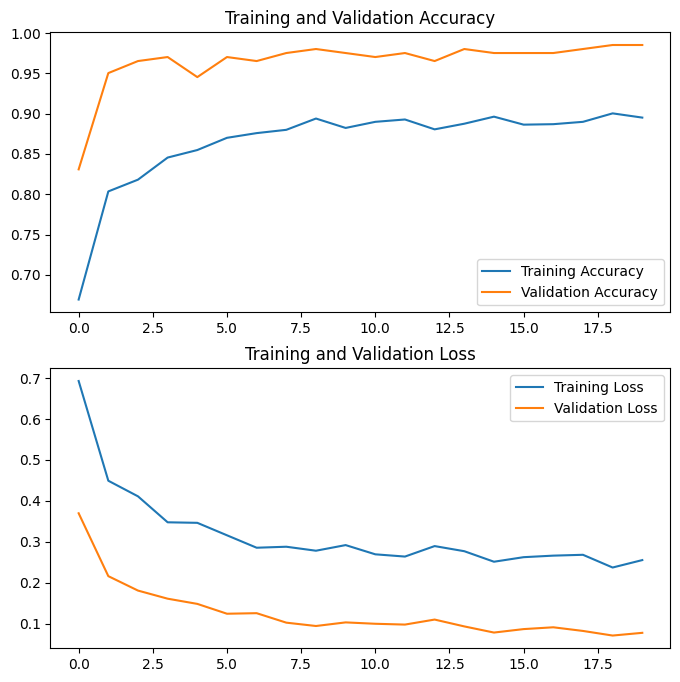

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Save the model to file
model.save('efb0_attention_model.keras')